# 04. PyTorch Custom Datasets

## 0. Import PyTorch and setup device-agnostic code

In [1]:
import copy

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

torch.__version__

'2.3.1'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data
For this module we will use the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). It encompasses 101 classes of 
distinct foods and 1000 images per class which makes a total of 101.000 images (75% train, 25% test).

Machine learning is an iterative process: start small, get something working, and increase when necessary. We will start with only three classes of 
the dataset (steak, sushi and pizza) and instead of 1000 images per class only a random 10%.

For starters, we will also use the pre-formated dataset from the course.

In [3]:
# Load pre-formated dataset
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"Did not find {image_path} directory. Creating new one")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)
        print('Donwload complete')

data\pizza_steak_sushi directory already exists


## 2. Become one with the data (data preparation)

Before starting a project or building any kind of model, it's important to know what data you're working with.

In our case, we have images of pizza, steak and sushi in standard image classification format.

Image classification format contains separate classes of images in separate directories titled with a particular class name.

For example, all images of pizza are contained in the pizza/ directory.

This format is popular across many different image classification benchmarks, including ImageNet (of the most popular computer vision benchmark datasets).

This is what the directory structure looks like:


```pizza_steak_sushi/ <- overall dataset folder
    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...
```

The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch.


We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`.

In [4]:
import os

def walk_through_dir(dir_path):
    for dir_path, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dir_path}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


Excellent! It looks like we have got 100 images per class, 75 for training and 25 for testing.

In [6]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'
print(train_dir)
print(test_dir)

data\pizza_steak_sushi\train
data\pizza_steak_sushi\test


### 2.1 Visualize images
1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


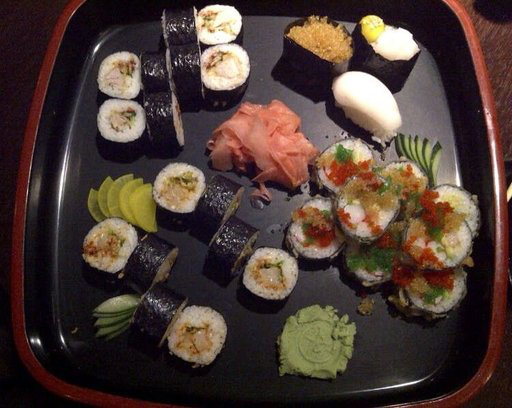

In [7]:
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path : Path = random.choice(image_path_list)
image_class  = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

We can achieve the same with `matplotlib.pyplot.imshow()` but we first have to convert the image to a NumPy array.

(-0.5, 511.5, 407.5, -0.5)

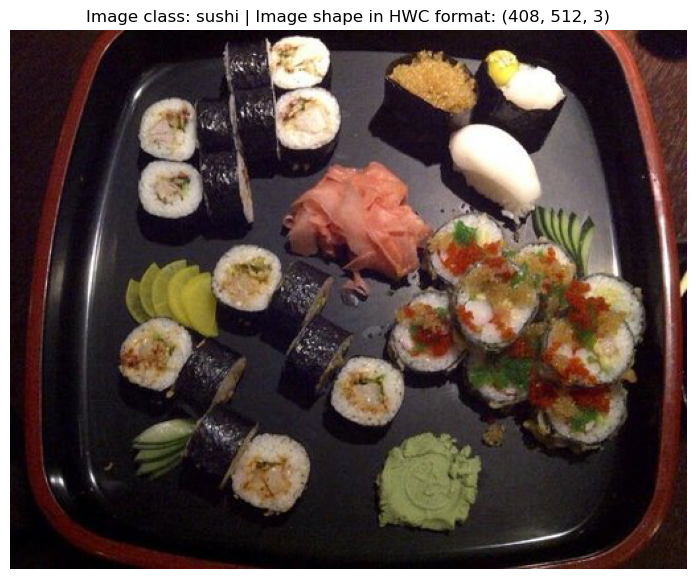

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class} | Image shape in HWC format: {img_array.shape}")
plt.axis(False)

## 3. Transforming data
How do we load the image data into PyTorch?

1. Turn it into a tensor
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

Torch has support for some common DL problems like vision , audio, text and recommender systems. We will use `torchvision.datasets` for our 
data loading functions and 
`torchvision.transforms for preparing our data.

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming the data
The first step is to transform the folders of images to tensors.

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

1. Resize the images using `transforms.Resize()` (from about 512x512 to 64x64, the same shape as the images on the CNN Explainer website).
2. Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because 
it will artificially change our image data).
3. Turn our images from a PIL image to a PyTorch tensor using `transforms.ToTensor()`.

We can compile all of these steps using `torchvision.transforms.Compose()`.

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

Let's try out the transform on random images and plot them.

In [11]:
from typing import List, Optional


def plot_transformed_images(image_paths: List[Path], transform: transforms.ToTensor, n: int=3, seed: Optional[int] = 42):
    random.seed(seed)
    random_img_paths: List[Path] = random.sample(image_paths, k=n)
    for img_path in random_img_paths:
        with Image.open(img_path) as img:
            fig, ax = plt.subplots(1, 2)
            # Plot original image in first column
            ax[0].imshow(img)
            ax[0].set_title(f"Original\nSize: {img.size}")
            ax[0].axis(False)
            
            # Plot transformed image in second column
            transformed_img = transform(img).permute(1, 2, 0).numpy()   # PyTorch default image format is CHW, PyPlot needs HWC
            ax[1].imshow(transformed_img)
            ax[1].set_title(f"Transformed\nSize: {transformed_img.shape}")
            ax[1].axis(False)
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

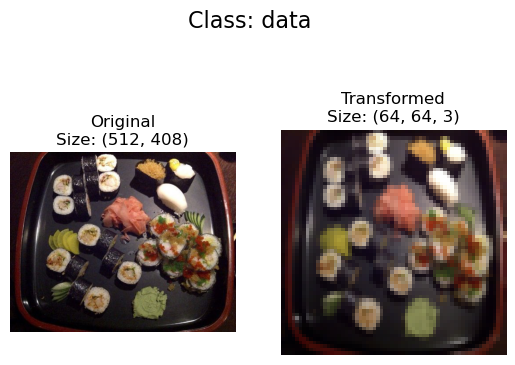

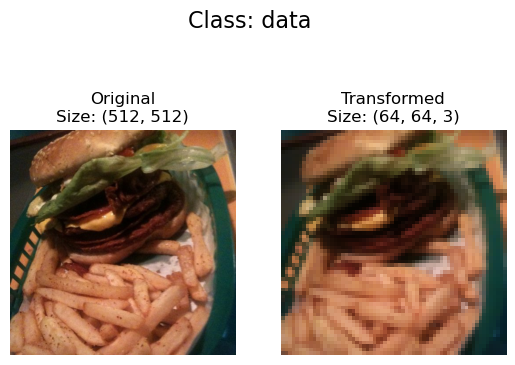

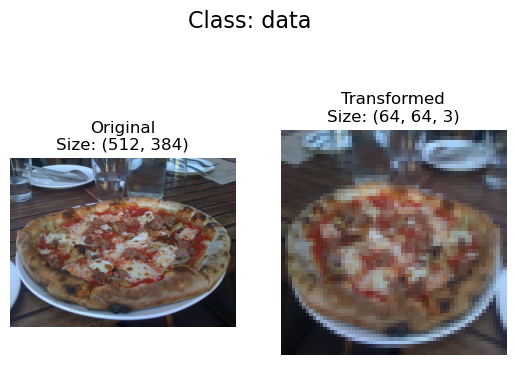

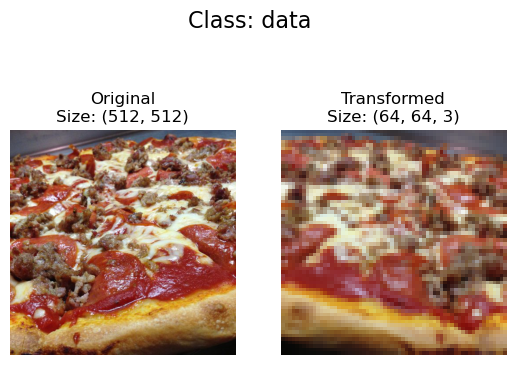

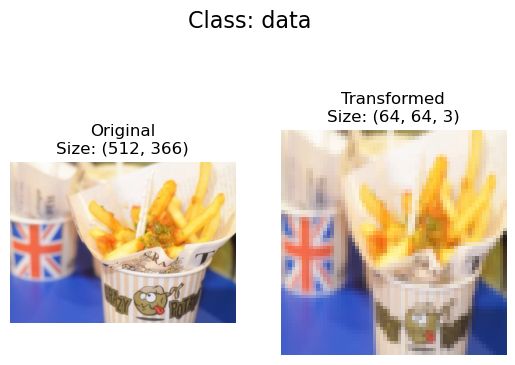

In [12]:
plot_transformed_images(image_path_list, data_transform, 5)

## 4. Option 1: Loading Image Data Using `Image Folder`
Now we need to turn out data into a `Dateset` so that it can be used with built-in PyTorch functionalities. Since our data is structured in the 
standard image classification format, we can use the `ImageFolder` class. It takes in a path to the data target directory and converts it into a 
`Dataset` and allows for transformations via the `transform`parameter. Let's turn our `train`_dir` and `test_dir` into datasets.

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(train_dir, data_transform)
test_data = datasets.ImageFolder(test_dir, data_transform)

print(f"Train data:\n{train_data}\n\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


It looks like PyTorch has registered our datasets. Let's check by calling the `classes` and `classes_to_idx` attributes.

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
len(train_data), len(test_data)

(225, 75)

We can index our datasets to find specific images and their labels.

In [17]:
img, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

### 4.1 Turn loaded images into `DataLoader`s
To keep things simple we will use`batch_size=1` and `num_workers=1`. `num_workers` specifies how many subprocesses will be created to load the data
. You can use Python's `os.cpu_count()` to match it with the number of CPUs in your machine.

In [18]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2400113f970>,
 <torch.utils.data.dataloader.DataLoader at 0x2400113f040>)

Now our data is iterable. Let's quickly check the shapes.

In [19]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


The image has shape `[1, 3, 64, 64]` because the dataloader does not load individual images but batches that contain only one images.

Before we dive into training we'll look at another way to load custom data that works for almost any kind of data.

## 5. Option 2: Loading Image Data with a Custom `Dataset`
What if no prebuilt `Dataset` creator like `torchvision.datasets.ImageFolder` exists for your specific problem? Then we can simply build our own.

In [20]:
import os   # for dealing with directories
import pathlib  # for dealing with filepaths
import torch

from PIL import Image   # class for loading images from filepaths
from torch.utils.data import Dataset
from torchvision import transforms

With our custom `Dataset` class we want to replicate the following two attributes:

In [21]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
Let's write a helper function capable of creating a list of class names and a dictionary associating the class names with their indices.

In [22]:
from typing import Tuple, Dict, List


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Find class folder names in the target directory.
    
    Assumes that tha target directory is in standard image classification format.
    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    
    # 1. Get sorted class names by scanning the directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if the class names are not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    # 3. Create a dictionary of index labels
    class_to_idx = {name: idx for idx, name in enumerate(classes)}
    return classes, class_to_idx

Let's test out our helper function.

In [23]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Looking good.

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`
Let's break it down:
1. Subclass `torch.utils.data.Dataset`
2. Initialize our subclass with `target_dir` and an optional`transform` parameter
3. Create attributes `paths` (path for target images), `transform`, `classes` and `class_to_idx`
4. Create a function to load an image from its file and return (for this we can use `PIL.Image` or `torchvision.io` for input/output of vision data)
5. Optionally overwrite `__len__()` allowing use to cal `len(Dataset)`.
6. Overwrite `__getitem__()`to get a single image, this is required.

In [24]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, target_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_dir)
       
    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.paths[index])
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx 

Later we could move this custom dataset class to a `data_loader.py` file alongside other helper functions for data and reuse it later.

Before we test our new class we will create some transforms to prepare our images

In [25]:
# Augment training data
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Simply reshape test data, don't augment
test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

Let's try to turn our images in our train and test directories into `Dataset`s using our custom `Dataset` class.

In [26]:
train_data = ImageFolderCustom(train_dir, train_transform)
test_data = ImageFolderCustom(test_dir, test_transform)

train_data, test_data

(<__main__.ImageFolderCustom at 0x24000ff1730>,
 <__main__.ImageFolderCustom at 0x24000ff1f10>)

In [27]:
len(train_data), len(test_data)

(225, 75)

In [28]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

Looks good. Now let's quickly write a function to plot random images to test our `__getitem__()` method.

### 5.3 Create a function to displays random images

In [29]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

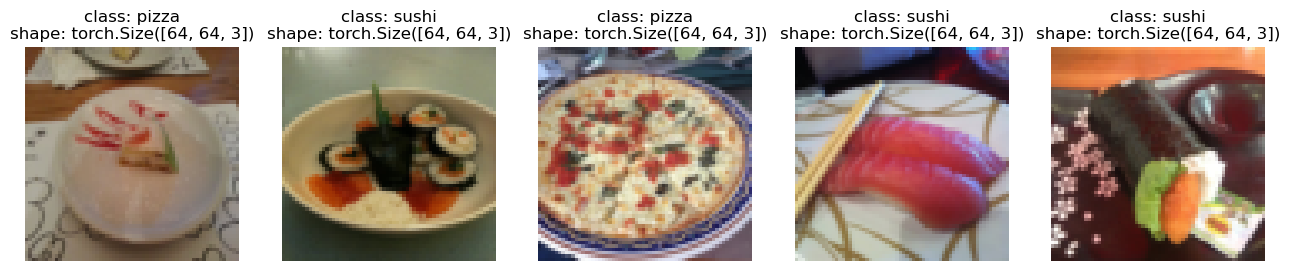

In [30]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`s

In [31]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2407f675700>,
 <torch.utils.data.dataloader.DataLoader at 0x24001125310>)

In [32]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}")
print(f"Image dtype: {img.dtype}")
print(f"Label shape: {label.shape}")
print(f"Label dtype: {label.dtype}")

Image shape: torch.Size([1, 3, 64, 64])
Image dtype: torch.float32
Label shape: torch.Size([1])
Label dtype: torch.int64


## 6. Other Transforms
Transforms can be useful for **data augmentation** which is the process of copying some of the samples and altering them slightly to artificially 
increase the diversity of the training data with the aim of improving the generalization of the models.

Research shows that using random transforms like `transforms.RandAugment()` or `transforms.TrivialAugmentWide()` generally perform better than 
handpicked transforms.

The main parameter to pay attention to with `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31` which controls the intensity range for the
 transform.

In [33]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])    

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

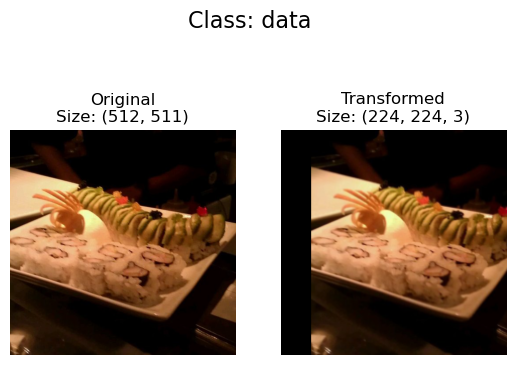

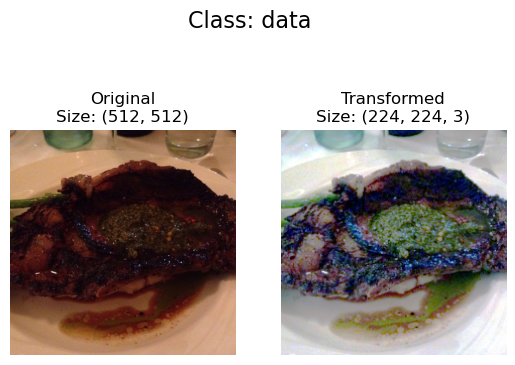

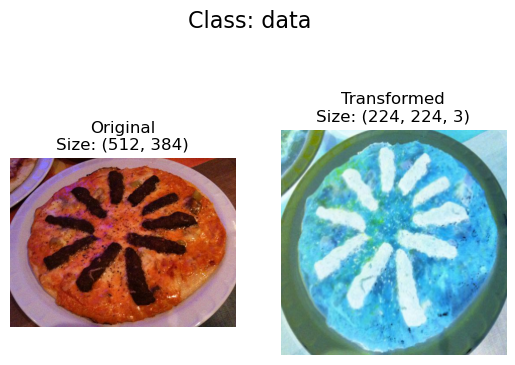

In [34]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3, seed=None)

## 7. Model 0: TinyVGG without data augmentation
Now that we got all helper functions for the data set up, we can start training our computer vision image classifier. To see what impact data 
augmentation has on generalization (here, performance on the test set), we will first train the model on the original data and then retrain the 
model on the augmented training data.

### 7.1 Creating transforms and loading data for Model 0
Let's define a simple transform that resizes the image to 64 pixels in height and width and turns the images into tensors.

In [35]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

Now, let's turn our folders with the image data (`train_dir` and `test_dir`) first into instances of our custom `Dataset` and then turn them into 
`DataLoader`s.

In [36]:
simple_train_data = ImageFolderCustom(target_dir=train_dir, transform=simple_transform)
simple_test_data = ImageFolderCustom(target_dir=test_dir, transform=simple_transform)

simple_train_dataloader = DataLoader(dataset=simple_train_data, batch_size=32, shuffle=True, num_workers=os.cpu_count())
simple_test_dataloader = DataLoader(dataset=simple_test_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())

simple_train_dataloader, simple_test_dataloader, os.cpu_count()

(<torch.utils.data.dataloader.DataLoader at 0x2407f704a30>,
 8)

### 7.2 Create TinyVGG model class
Now we will build a model to classify our images. We will go with the TinyVGG architecture from the previous chapter. It is a CNN and did pretty 
well on the MNIST datasets.

In [37]:
from torch import nn

class Conv2dBlock(nn.Module):
    def __init__(self, in_channels: int, hidden_units: int, out_channels: int):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv_maxpool_layer = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv_maxpool_layer(self.conv_layer(x))
    


class TinyVGG(nn.Module):
    def __init__(self, in_shape: Tuple[int, int, int], hidden_units: int, out_classes: int, num_blocks: int):
        super().__init__()
        self.num_blocks = num_blocks
        self.block_1 = Conv2dBlock(in_channels=in_shape[0], hidden_units=hidden_units, out_channels=hidden_units)
        self.block_2 = Conv2dBlock(in_channels=hidden_units, hidden_units=hidden_units, out_channels=hidden_units)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=int(hidden_units * (in_shape[1] * in_shape[2] / 4**num_blocks)), out_features=out_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

Here is how we will choose the hyperparameters for the model architecture:
- We want to classify 64x64 pixel images with 3 color channels in CHW format
- We want to use 10 kernels per channel per convolutional layer
- We have to input the number of classes that our dataset has
- We want to use 2 convolutional blocks to classify the images

In [74]:
model_0 = TinyVGG(in_shape=(3, 64, 64), hidden_units=10, out_classes=3, num_blocks=2).to(device)

model_0

TinyVGG(
  (block_1): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block_2): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)
Let's test whether we did not make any mistakes when putting the model together and pass a single image through our model.

In [39]:
image, label = simple_train_data[0]
image = image.unsqueeze(dim=0)  # Add dimension so shape fits the model
image.shape

torch.Size([1, 3, 64, 64])

In [40]:
# Forward pass
model_0.eval()
with torch.inference_mode():
    logits: torch.Tensor = model_0(image.to(device))
    probs = logits.softmax(dim=1)
    pred = probs.argmax(dim=1)

print(f"Output logits:\n{logits}\n")
print(f"Prediction probabilities:\n{probs}\n")
print("Prediction:", pred.item(), class_names[pred.item()])
print("Actual class:", label, class_names[label])

Output logits:
tensor([[ 0.0166, -0.0221, -0.0280]])

Prediction probabilities:
tensor([[0.3426, 0.3296, 0.3277]])

Prediction: 0 pizza
Actual class: 0 pizza


### 7.4 Use `torchinfo`to get an idea of the shapes going through our model
Instead of using print statements in thr `forward()` method of the model we can use `torchinfo` which comes with a `summary()` method that takes a 
PyTorch model and an `input_shape` as arguments and documents the shapes for each layer and operation in the forward pass.

In [41]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [42]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Conv2dBlock: 1-1                       [1, 10, 32, 32]           --
│    └─Sequential: 2-1                   [1, 10, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 10, 64, 64]           280
│    │    └─ReLU: 3-2                    [1, 10, 64, 64]           --
│    └─Sequential: 2-2                   [1, 10, 32, 32]           --
│    │    └─Conv2d: 3-3                  [1, 10, 64, 64]           910
│    │    └─ReLU: 3-4                    [1, 10, 64, 64]           --
│    │    └─MaxPool2d: 3-5               [1, 10, 32, 32]           --
├─Conv2dBlock: 1-2                       [1, 10, 16, 16]           --
│    └─Sequential: 2-3                   [1, 10, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 10, 32, 32]           910
│    │    └─ReLU: 3-7                    [1, 10, 32, 32]           --
│    └─Seque

Skipping subchapters 7.5 and 7.6 since I already functionalized the training-testing loop.

### 7.7 Train and evaluate Model 0

In [75]:
import torch
from torch import nn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.001, momentum=0.9)

In [76]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, F1Score, AUROC

train_metrics = MetricCollection({
    'accuracy': Accuracy(task='multiclass', num_classes=len(class_names), average='macro'),
    'f1-score': F1Score(task='multiclass', num_classes=len(class_names), average='macro'),
    'auroc': AUROC(task='multiclass', num_classes=len(class_names), average='macro')
})

train_metric_tracker = MetricTracker(train_metrics)
test_metric_tracker = copy.deepcopy(train_metric_tracker)

train_metric_tracker, test_metric_tracker

(MetricTracker(
   (0): MetricCollection(
     (accuracy): MulticlassAccuracy()
     (auroc): MulticlassAUROC()
     (f1-score): MulticlassF1Score()
   )
 ),
 MetricTracker(
   (0): MetricCollection(
     (accuracy): MulticlassAccuracy()
     (auroc): MulticlassAUROC()
     (f1-score): MulticlassF1Score()
   )
 ))

In [77]:
from helper_functions import train_test_loop
from timeit import default_timer as timer

start_time = timer()

train_losses, test_losses, train_metric_tracker, test_metric_tracker = train_test_loop(
    model=model_0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=5,
    device=device,
    train_metric_tracker=train_metric_tracker,
    test_metric_tracker=test_metric_tracker
)

end_time = timer()
train_time = end_time - start_time
print(f"Total training time: {train_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1
--------------------------------
TRAINING EVAL
Loss: 1.1021
Accuracy: 0.3012
Auroc: 0.4843
F1-score: 0.2675
--------------------------------
TEST EVAL
Loss: 1.1047
Accuracy: 0.4582
Auroc: 0.6366
F1-score: 0.3228
EPOCH 2
--------------------------------
TRAINING EVAL
Loss: 1.0649
Accuracy: 0.4456
Auroc: 0.6032
F1-score: 0.4365
--------------------------------
TEST EVAL
Loss: 1.1032
Accuracy: 0.4604
Auroc: 0.6345
F1-score: 0.3663
EPOCH 3
--------------------------------
TRAINING EVAL
Loss: 0.9991
Accuracy: 0.5169
Auroc: 0.6828
F1-score: 0.5111
--------------------------------
TEST EVAL
Loss: 0.9923
Accuracy: 0.5047
Auroc: 0.7048
F1-score: 0.4979
EPOCH 4
--------------------------------
TRAINING EVAL
Loss: 0.9897
Accuracy: 0.5251
Auroc: 0.6855
F1-score: 0.5224
--------------------------------
TEST EVAL
Loss: 0.9758
Accuracy: 0.4677
Auroc: 0.6656
F1-score: 0.4644
EPOCH 5
--------------------------------
TRAINING EVAL
Loss: 0.9282
Accuracy: 0.5469
Auroc: 0.7169
F1-score: 0.5443
----

It looks like out model is performing is not performing too well (so is the one of the course creator).

### 7.8 Plot loss curves of Model 0
Let's create a functio to plot the loss of the model

In [98]:
def plot_metric_curves(metric_dict_1: Dict[str, List[float]], metric_dict_2: Dict[str, List[float]], label_1: str='Train', label_2: str='Test') -> \
        None:
    """
    Create a plot for each metric in the two metric dictionaries and plot the values of both dictionaries in the plot for comparison.
    
    The two dictionaries must be of the same length and must contain the same metrics in the same order.
    
    The string key of each metric in the dictionary will be used as its display name
    :param metric_dict_1: The computed metrics 1
    :param metric_dict_2: The computed metrics
    """
    if metric_dict_1.keys() != metric_dict_2.keys():
        raise AssertionError("train_metrics and test_metrics must have the same length and contain the same metrics in the same order")
    num_metrics = len(metric_dict_1)
    rows, cols = int(np.ceil(num_metrics / 2)), 2
    plt.figure(figsize=(13, 5 * rows))
    for i, metric_name in enumerate(metric_dict_1.keys()):
        metric_values_1 = metric_dict_1[metric_name]
        metric_values_2 = metric_dict_2[metric_name]
        
        epochs = range(1, max(len(metric_values_1), len(metric_values_2)) + 1)
        
        plt.subplot(rows, cols, i + 1)
        plt.plot(epochs, metric_values_1, label=label_1)
        plt.plot(epochs, metric_values_2, label=label_2)
        plt.title(f'{str(metric_name).capitalize()}')
        plt.xlabel('Epochs')
        plt.xticks(epochs, epochs)
        plt.ylabel(metric_name)
        plt.legend()


In [79]:
def get_metric_dicts(train_losses: List[float], test_losses: List[float], train_metric_tracker: MetricTracker, test_metric_tracker: MetricTracker) \
        -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    train_metric_values = {name: values.numpy() for name, values in train_metric_tracker.compute_all().items()}
    train_metric_values['loss'] = train_losses
    test_metric_values = {name: values.numpy() for name, values in test_metric_tracker.compute_all().items()}
    test_metric_values['loss'] = test_losses
    return train_metric_values, test_metric_values

In [80]:
train_metric_values, test_metric_values = get_metric_dicts(train_losses, test_losses, train_metric_tracker, test_metric_tracker)

print(f"Train metrics:\n{train_metric_values}")
print(f"Test metrics:\n{test_metric_values}")

Train metrics:
{'accuracy': array([0.30122507, 0.44555557, 0.5169088 , 0.5251282 , 0.5468661 ],
      dtype=float32), 'auroc': array([0.4843413 , 0.60317117, 0.6828222 , 0.6854742 , 0.7168557 ],
      dtype=float32), 'f1-score': array([0.30122507, 0.44555557, 0.5169088 , 0.5251282 , 0.5468661 ],
      dtype=float32), 'loss': [1.102069919374254, 1.0649147617816925, 0.9990707402759128, 0.9896515877710448, 0.9282181472082933]}
Test metrics:
{'accuracy': array([0.4582456 , 0.46035087, 0.50471985, 0.46773058, 0.49740803],
      dtype=float32), 'auroc': array([0.6365807 , 0.6345369 , 0.70476264, 0.66559964, 0.667382  ],
      dtype=float32), 'f1-score': array([0.4582456 , 0.46035087, 0.50471985, 0.46773058, 0.49740803],
      dtype=float32), 'loss': [1.104653040568034, 1.1031603614489238, 0.9922949274381002, 0.9758031765619913, 0.9614893595377604]}


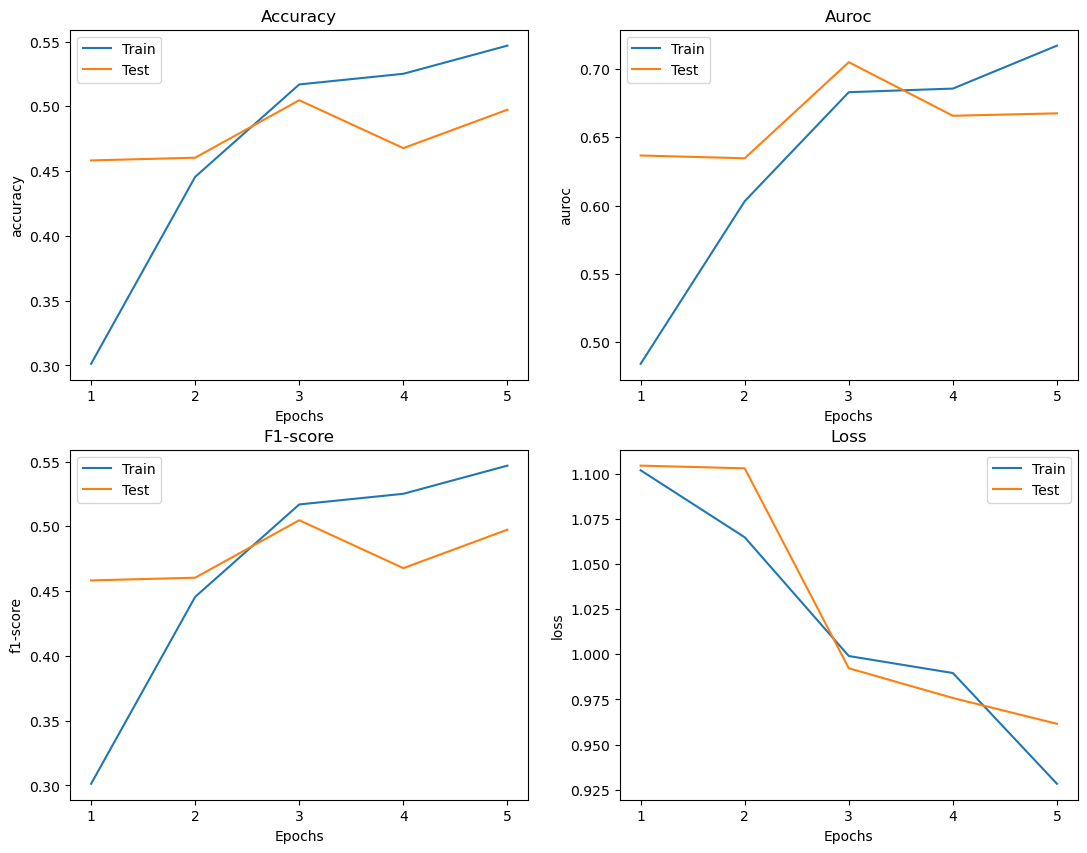

In [81]:
plot_metric_curves(train_metric_values, test_metric_values)

The curves are all over the place. It looks like our model has not converged yet. Let's try training it for 10 more epochs.

## 8. Train Model 0 for longer
Let's train the model for 10 more epochs.

In [82]:
extra_train_losses, extra_test_losses, train_metric_tracker, test_metric_tracker = train_test_loop(
    model=model_0,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    device=device,
    train_metric_tracker=train_metric_tracker,
    test_metric_tracker=test_metric_tracker
)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1
--------------------------------
TRAINING EVAL
Loss: 0.9113
Accuracy: 0.6004
Auroc: 0.7617
F1-score: 0.5952
--------------------------------
TEST EVAL
Loss: 1.0435
Accuracy: 0.5445
Auroc: 0.7300
F1-score: 0.4594
EPOCH 2
--------------------------------
TRAINING EVAL
Loss: 0.8418
Accuracy: 0.6093
Auroc: 0.7960
F1-score: 0.6019
--------------------------------
TEST EVAL
Loss: 0.9762
Accuracy: 0.4731
Auroc: 0.6669
F1-score: 0.4779
EPOCH 3
--------------------------------
TRAINING EVAL
Loss: 0.8646
Accuracy: 0.5954
Auroc: 0.7843
F1-score: 0.5913
--------------------------------
TEST EVAL
Loss: 1.0082
Accuracy: 0.4322
Auroc: 0.6825
F1-score: 0.4242
EPOCH 4
--------------------------------
TRAINING EVAL
Loss: 0.8258
Accuracy: 0.6045
Auroc: 0.8062
F1-score: 0.5991
--------------------------------
TEST EVAL
Loss: 0.9655
Accuracy: 0.4109
Auroc: 0.6722
F1-score: 0.4207
EPOCH 5
--------------------------------
TRAINING EVAL
Loss: 0.7736
Accuracy: 0.6583
Auroc: 0.8309
F1-score: 0.6573
----

In [83]:
train_losses += extra_train_losses
test_losses += extra_test_losses

train_metric_values, test_metric_values = get_metric_dicts(train_losses, test_losses, train_metric_tracker, test_metric_tracker)

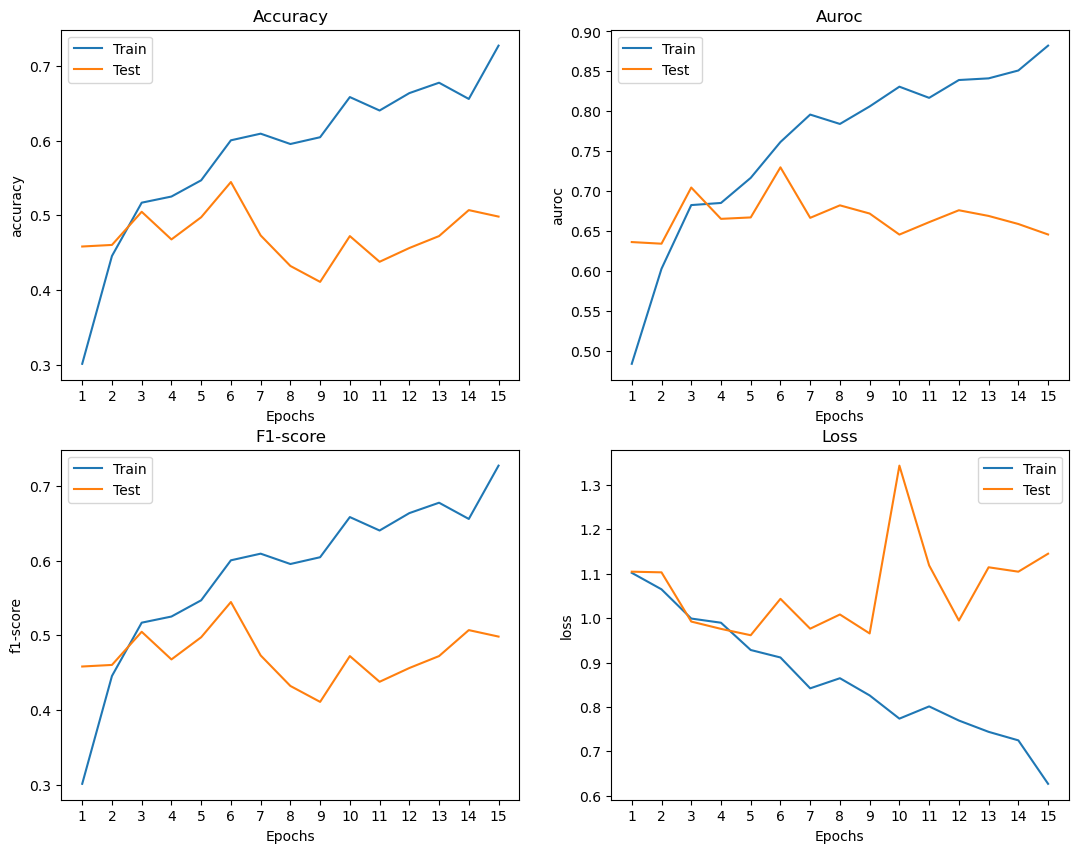

In [84]:
plot_metric_curves(train_metric_values, test_metric_values)

Uff, this doesn't look good. Training the model for longer only resulted in divergence on the test set.
Currently, it looks like our model is slightly overfitting to the test set (spread between train and test curves) and at the same time has a hard 
time learning the patterns (performance on the training set is relatively low).

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [61]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

### 9.2 Create train and test dataloaders

In [72]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data = datasets.ImageFolder(test_dir, transform=simple_transform)

train_data_augmented, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [73]:
train_dataloader_augmented = DataLoader(train_data_augmented, batch_size=32, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=os.cpu_count())

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x24008568490>,
 <torch.utils.data.dataloader.DataLoader at 0x24008568130>)

### 9.3 Construct and train Model 1

In [66]:
torch.manual_seed(42)
model_1 = TinyVGG(in_shape=(3, 64, 64), hidden_units=10, out_classes=len(class_names), num_blocks=2)

model_1

TinyVGG(
  (block_1): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (block_2): Conv2dBlock(
    (conv_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (conv_maxpool_layer): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [85]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.001, momentum=0.9)

In [93]:
train_metric_tracker_1 = MetricTracker(copy.deepcopy(train_metrics))
test_metric_tracker_1 = copy.deepcopy(train_metric_tracker_1)

In [95]:
from timeit import default_timer as timer

start_time = timer()
train_losses_1, test_losses_1, train_metric_tracker_1, test_metric_tracker_1 = train_test_loop(
    model=model_1,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader,
    epochs=15,
    device=device,
    train_metric_tracker=train_metric_tracker_1,
    test_metric_tracker=test_metric_tracker_1
)
end_time = timer()
train_time = end_time - start_time
print(f"Total training time: {train_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

EPOCH 1
--------------------------------
TRAINING EVAL
Loss: 1.1018
Accuracy: 0.3205
Auroc: 0.4337
F1-score: 0.1701
--------------------------------
TEST EVAL
Loss: 1.1032
Accuracy: 0.3333
Auroc: 0.5464
F1-score: 0.1667
EPOCH 2
--------------------------------
TRAINING EVAL
Loss: 1.1023
Accuracy: 0.3031
Auroc: 0.4576
F1-score: 0.2418
--------------------------------
TEST EVAL
Loss: 1.0915
Accuracy: 0.3333
Auroc: 0.5260
F1-score: 0.1950
EPOCH 3
--------------------------------
TRAINING EVAL
Loss: 1.0970
Accuracy: 0.3378
Auroc: 0.5046
F1-score: 0.1718
--------------------------------
TEST EVAL
Loss: 1.0985
Accuracy: 0.3333
Auroc: 0.5330
F1-score: 0.1348
EPOCH 4
--------------------------------
TRAINING EVAL
Loss: 1.0924
Accuracy: 0.3333
Auroc: 0.4681
F1-score: 0.1667
--------------------------------
TEST EVAL
Loss: 1.1142
Accuracy: 0.3333
Auroc: 0.5558
F1-score: 0.1348
EPOCH 5
--------------------------------
TRAINING EVAL
Loss: 1.1101
Accuracy: 0.3333
Auroc: 0.4846
F1-score: 0.1667
----

In [96]:
train_metric_values_1, test_metric_values_1 = get_metric_dicts(train_losses_1, test_losses_1, train_metric_tracker_1, test_metric_tracker_1)
train_metric_values_1, test_metric_values_1

({'accuracy': array([0.3205128 , 0.30306268, 0.3377778 , 0.33333334, 0.33333334,
         0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.35179487,
         0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334],
        dtype=float32),
  'auroc': array([0.43365178, 0.4575852 , 0.5045819 , 0.4681226 , 0.48458397,
         0.46433577, 0.42601848, 0.4499823 , 0.5176573 , 0.51248556,
         0.51371783, 0.47904256, 0.48686862, 0.5187126 , 0.5071455 ],
        dtype=float32),
  'f1-score': array([0.3205128 , 0.30306268, 0.3377778 , 0.33333334, 0.33333334,
         0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.35179487,
         0.33333334, 0.33333334, 0.33333334, 0.33333334, 0.33333334],
        dtype=float32),
  'loss': [1.1017515510320663,
   1.1022648811340332,
   1.0969852805137634,
   1.0924402624368668,
   1.110069140791893,
   1.0902844220399857,
   1.107251152396202,
   1.111437812447548,
   1.1025143712759018,
   1.092577502131462,
   1.0855848342180252,
   1.113394349

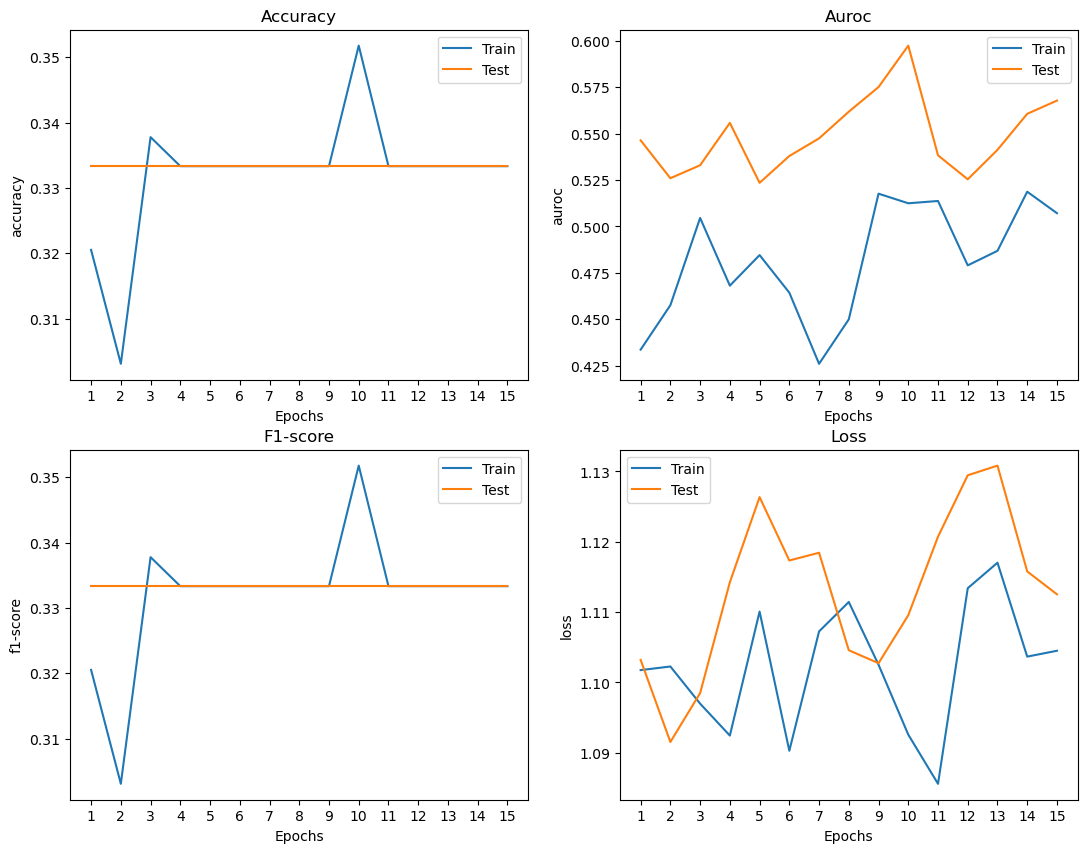

In [97]:
plot_metric_curves(train_metric_values_1, test_metric_values_1)

It looks like the data augmentation did not help in this case. Model 1 also diverges on the test set. We could tweak the optimizer setting some 
more to rule out the possibility that the model is getting stuck in pathological curvature of the loss optimization landscape.

Let's compare the performance of the two models.

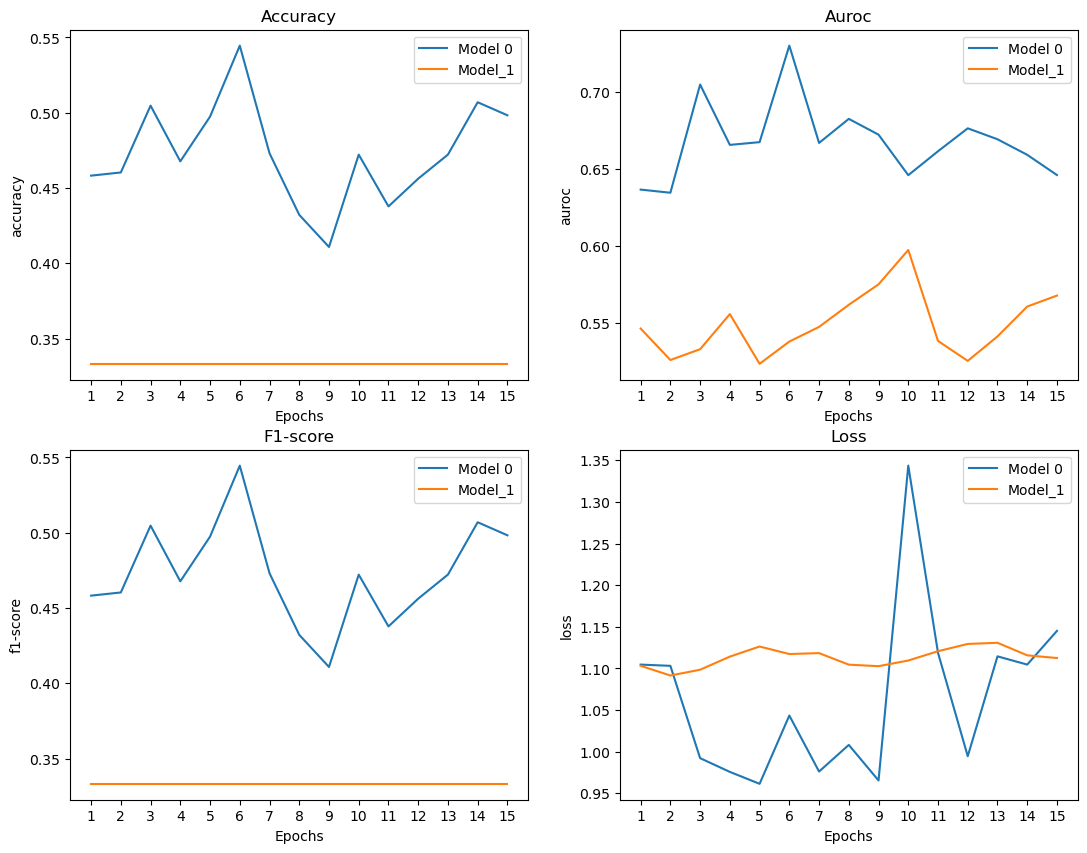

In [99]:
plot_metric_curves(test_metric_values, test_metric_values_1, 'Model 0', 'Model_1')

Even though both models performed poorly, Model 0 clearly outperformed Model 1.